In [ ]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    """ Applies attention mechanism on the `context` using the `query`.

    **Thank you** to IBM for their initial implementation of :class:`Attention`. Here is
    their `License
    <https://github.com/IBM/pytorch-seq2seq/blob/master/LICENSE>`__.

    Args:
        dimensions (int): Dimensionality of the query and context.
        attention_type (str, optional): How to compute the attention score:

            * dot: :math:`score(H_j,q) = H_j^T q`
            * general: :math:`score(H_j, q) = H_j^T W_a q`

    Example:

         >>> attention = Attention(256)
         >>> query = torch.randn(5, 1, 256)
         >>> context = torch.randn(5, 5, 256)
         >>> output, weights = attention(query, context)
         >>> output.size()
         torch.Size([5, 1, 256])
         >>> weights.size()
         torch.Size([5, 1, 5])
    """

    def __init__(self, dimensions, attention_type='dot'): # USING DOT PRODUCT ATTENTION
        super(Attention, self).__init__()

        if attention_type not in ['dot', 'general']:
            raise ValueError('Invalid attention type selected.')

        self.attention_type = attention_type
        if self.attention_type == 'general':
            self.linear_in = nn.Linear(dimensions, dimensions, bias=False)

        self.linear_out = nn.Linear(dimensions * 2, dimensions, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, query, context):
        """
        Args:
            query (:class:`torch.FloatTensor` [batch size, output length, dimensions]): Sequence of
                queries to query the context.
            context (:class:`torch.FloatTensor` [batch size, query length, dimensions]): Data
                overwhich to apply the attention mechanism.

        Returns:
            :class:`tuple` with `output` and `weights`:
            * **output** (:class:`torch.LongTensor` [batch size, output length, dimensions]):
              Tensor containing the attended features.
            * **weights** (:class:`torch.FloatTensor` [batch size, output length, query length]):
              Tensor containing attention weights.
        """
        batch_size, output_len, dimensions = query.size()
        query_len = context.size(1)

        if self.attention_type == "general":
            query = query.reshape(batch_size * output_len, dimensions)
            query = self.linear_in(query)
            query = query.reshape(batch_size, output_len, dimensions)

        # TODO: Include mask on PADDING_INDEX?

        # (batch_size, output_len, dimensions) * (batch_size, query_len, dimensions) ->
        # (batch_size, output_len, query_len)
        attention_scores = torch.bmm(query, context.transpose(1, 2).contiguous())

        # Compute weights across every context sequence
        attention_scores = attention_scores.view(batch_size * output_len, query_len)
        #import pdb; pdb.set_trace() # Check for attention scores
        attention_weights = self.softmax(attention_scores)
        attention_weights = attention_weights.view(batch_size, output_len, query_len)

        # (batch_size, output_len, query_len) * (batch_size, query_len, dimensions) ->
        # (batch_size, output_len, dimensions)
        mix = torch.bmm(attention_weights, context)

        # concat -> (batch_size * output_len, 2*dimensions)
        combined = torch.cat((mix, query), dim=2)
        combined = combined.view(batch_size * output_len, 2 * dimensions)

        # Apply linear_out on every 2nd dimension of concat
        # output -> (batch_size, output_len, dimensions)
        output = self.linear_out(combined).view(batch_size, output_len, dimensions)
        output = self.tanh(output)

        return output, attention_weights

In [ ]:
!pip install transformers
import time
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math

In [ ]:
#Useful functions

def find_max_mode(list1):
    list_table = statistics._counts(list1)
    len_table = len(list_table)

    if len_table == 1:
        max_mode = statistics.mode(list1)
    else:
        new_list = []
        for i in range(len_table):
            new_list.append(list_table[i][0])
        max_mode = max(new_list) # use the max value here
    return max_mode

def rectified(x):
	return max(0.0, x)

In [ ]:
from transformers import AutoTokenizer, AutoModel, AutoModelForQuestionAnswering

#LOAD QA MODEL
model_name_or_path = "bert-base-uncased" # Uncased avoids weird attention spikes on the discrimination task. For example, "Are" vs "are"
attention_size = 768 # 768 for bert-base
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
model = AutoModelForQuestionAnswering.from_pretrained(model_name_or_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#LOAD QA MODEL
model_name_or_path = "mrm8488/spanbert-finetuned-squadv2" # This model tends to produce embeddings that are worse for the discriminator task, but the model performs better at the QA task
model_qa = AutoModelForQuestionAnswering.from_pretrained(model_name_or_path)
tokenizer_qa = AutoTokenizer.from_pretrained(model_name_or_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_qa = model_qa.to(device)

print('success!')
# Note: Very interesting result is that bert-base-uncased seems to have much noisier attention than the fine-tuned spanbert, but bert-base-uncased seems to have fewer freak errors and picks discriminators more reliably. Why? Maybe because the discrimination task is actually just an LM task, which is different from QA.

In [ ]:
# BUILDING FUNCTION FOR DISCRIMINATOR FINDER USING MAX MINUS MODE ATTENTION DIFFERENCE

def find_max_discriminator(question_list, context):
  num_questions = len(question_list)
  discrimination_strength = {}
  max_discriminator_embedding_list = []
  max_discriminator_token_list = []
  
  for qxn in range(num_questions):
    question = question_list[qxn] # Set question.
    discrimination_strength.clear()
    question_ids = tokenizer.encode(question, return_tensors="pt")
    question_tokens = tokenizer.convert_ids_to_tokens(question_ids[0])
    question_length = len(question_ids[0])
    for ind in range(question_length):
      current_id = question_ids[0][ind:ind+1].unsqueeze(0)
      current_token = tokenizer.convert_ids_to_tokens(current_id.item())
      current_embedding = model.bert.embeddings.word_embeddings(current_id) # These are raw embeddings.
      output, weights = attention(current_embedding, context_embeddings)
      y = weights[0][0].tolist()
      difference = max(y) - find_max_mode(y)
      close_difference = difference*(3/4)
      word_count = len([i for i in y if i > close_difference]) # Count number of words above threshold of 95% range
      print(f"The word count for {current_token} is {word_count}")
      if current_token != '[CLS]': # We don't want to include the [CLS] token in the attention comparison
        print(f"The word-count adjustment for {current_token} is {math.sqrt(word_count)}")
        discrimination_strength[current_id] = difference
        discrimination_strength[current_id] = difference / math.sqrt(word_count) # Discriminate by difference and by count
        print(f"The discrimination strength for {current_token} is {discrimination_strength[current_id]}") # Print discrimination strength
        if discrimination_strength[current_id] >= max(discrimination_strength.values()):
          max_discriminator = current_id
          #print(f"Best discriminator updated to {current_token}")
    max_discriminator_embedding = model.bert.embeddings.word_embeddings(max_discriminator)
    max_discriminator_token = tokenizer.convert_ids_to_tokens(max_discriminator)
    print(f"{qxn}: The maximum discriminator token for question '{question}' is {max_discriminator_token}")
    print(" ")
    max_discriminator_embedding_list.append(max_discriminator_embedding)
    max_discriminator_token_list.append(max_discriminator_token)
  return max_discriminator_embedding_list, max_discriminator_token_list

  #The main problem with this discriminator is when two things are true: 
  #a) There is an exact match to a relatively distinct word (such as "mile" in "what is the name of the prison in the green mile") 
  #that distracts from a non-exact match of a more pertinent word (such as "prison" in the previous sentence, 
  #which is mismatched against the true use of "penitentiary" in the context). The attention difference between the exact match and the
  #inexact match will almost always wash things out.

In [ ]:
# STORE ALL QUESTION TOKENS FROM ONE QUESTION FOR INVESTIGATION

def find_token_attentions(question_list, context, which_question):
  #num_questions = len(question_list)
  token_embedding_list = []
  token_list = []
  
  #for qxn in range(num_questions):
  question = question_list[which_question] # Set question.
  question_ids = tokenizer.encode(question, return_tensors="pt")
  question_tokens = tokenizer.convert_ids_to_tokens(question_ids[0])
  question_length = len(question_ids[0])
  for ind in range(question_length):
    current_id = question_ids[0][ind:ind+1].unsqueeze(0)
    current_token = tokenizer.convert_ids_to_tokens(current_id.item())
    current_embedding = model.bert.embeddings.word_embeddings(current_id) # These are raw embeddings.
      #output, weights = attention(current_embedding, context_embeddings)
      #y = weights[0][0].tolist()
      #difference = max(y) - find_max_mode(y)
      #if current_token != '[CLS]': # We don't want to include the [CLS] token in the attention comparison
        #discrimination_strength[current_id] = difference
        #print(f"The discrimination strength for {current_token} is {difference}") # Print discrimination strength
        #if difference >= max(discrimination_strength.values()):
          #max_discriminator = current_id
          #print(f"Best discriminator updated to {current_token}")
    #max_discriminator_embedding = model.bert.embeddings.word_embeddings(max_discriminator)
    #max_discriminator_token = tokenizer.convert_ids_to_tokens(max_discriminator)
    #print(f"{qxn}: The maximum discriminator token for question '{question}' is {max_discriminator_token}")
    token_embedding_list.append(current_embedding)
    token_list.append(current_token)
  return token_embedding_list,token_list

In [ ]:
context = f"""Rules Conflicts {tokenizer.sep_token}
Precedence. If a card conflicts with the Law, follow the card. If the Learning to Play guide conflicts with the Law, follow the Law. If you can follow both a general rule and a faction rule, follow both; if you cannot, follow the faction rule. {tokenizer.sep_token}
Use of Cannot. The term cannot is absolute. It cannot be overridden unless explicitly instructed. {tokenizer.sep_token}
Simultaneous Effects. If two game effects occur simultaneously, the player taking the current turn chooses their order, unless explicitly instructed. {tokenizer.sep_token}
Use of Treat. If you are prompted to treat one thing as another, the former takes on all the properties of the latter. (For example, if you caused Outrage while treating yourself as another player, the other player would give the card.) {tokenizer.sep_token}
Public and Private Information {tokenizer.sep_token}
Hands. Players may only show or reveal cards in their hand if explicitly instructed, but the number of cards in their hand is public information.{tokenizer.sep_token}
Discard. The discard pile can be searched and inspected at any time. {tokenizer.sep_token}
Negotiation and Deals {tokenizer.sep_token}
Agreements. Players may discuss the game and make agreements, but they are non-binding. {tokenizer.sep_token}
Cards. Players may only give cards to each other if explicitly instructed. {tokenizer.sep_token}
Players and Factions {tokenizer.sep_token}
For simplicity, the Law refers to players, not factions. However, game effects (such as abilities and persistent effects) are properties of factions, not players. While controlling pieces of a faction they do not own, a player follows the rules of that faction unless explicitly instructed. {tokenizer.sep_token}
Game Structure {tokenizer.sep_token}
Each player’s turn has three phases: Birdsong, Daylight, and Evening. After a player completes all three phases, the next clockwise player begins their turn. Play continues until one player has won the game (3.1). {tokenizer.sep_token}
Key Terms and Concepts {tokenizer.sep_token}
Cards {tokenizer.sep_token}
Each card has a suit: bird, fox, rabbit, or mouse. Most cards also have an effect you can craft (4.1). {tokenizer.sep_token}
Birds Are Wild. You can treat any bird card as a card of another suit, even if you must spend, take, or give multiple cards of the same suit. {tokenizer.sep_token}
Forced Effects. If you are prompted to discard or give a fox, rabbit, or mouse card, you must treat your bird cards as the prompted suit. {tokenizer.sep_token}
Reverse Substitution. If you are prompted to spend, discard, take, or give a bird card, you cannot substitute a card of another suit. {tokenizer.sep_token}
Drawing Cards. Whenever you are prompted to draw a card, take it from the shared deck. If the deck is ever empty, shuffle the discard pile immediately to form a new deck. {tokenizer.sep_token}
Spending and Discarding Cards. Whenever you are prompted to discard or spend a card, place it in the shared discard pile unless it is a dominance card (3.3). {tokenizer.sep_token}
Revealing Cards. Whenever you are prompted to reveal a card, place it in your play area (2.6). {tokenizer.sep_token}
Ambush Cards. There are five ambush cards: one mouse, one rabbit, one fox, and two birds. You may spend an ambush card for its suit, but it does not have a crafted effect. You may also play one in battle to deal hits (4.3.1). {tokenizer.sep_token}
Dominance Cards. There are four dominance cards matching the four suits. You may spend a dominance card for its suit, but it cannot be crafted. You may also play one to permanently change your victory condition (3.3). {tokenizer.sep_token}
Clearings and Paths {tokenizer.sep_token}
The map of the Woodland is composed of many clearings linked by paths. {tokenizer.sep_token}
Adjacency. A clearing is adjacent to all other clearings linked to it by a path. {tokenizer.sep_token}
Suit. Each clearing has a suit: mouse, rabbit, or fox. {tokenizer.sep_token}
Slots. Each clearing has a number of slots (white boxes). Whenever you place a building, it fills an open slot. You cannot place a building in a clearing with no open slots. {tokenizer.sep_token}
Ruins. Slots marked with a small “R” begin the game filled with ruins. Ruins can only be removed by the Vagabond’s Explore action (9.5.3). {tokenizer.sep_token}
Rivers {tokenizer.sep_token}
Many clearings are linked by rivers. By default rivers are not paths, but can be treated as paths if explicitly instructed. Rivers do not divide clearings or forests. {tokenizer.sep_token} 
Forests {tokenizer.sep_token}
Areas on the map enclosed by paths and clearings are called forests. {tokenizer.sep_token}
Adjacency. A forest is adjacent to all clearings that touch it without crossing a path, and it is adjacent to all forests that are separated by only one path. {tokenizer.sep_token}
Pieces {tokenizer.sep_token}
Each faction has a set of pieces listed on the back of its faction board. Pieces are limited by the contents of the game. If you are prompted to place, take, or remove any number of pieces but you cannot, you must place, take, or remove the maximum number possible. {tokenizer.sep_token}
Warriors. If you are prompted to place a warrior, take it from your supply. If one of your warriors is removed, return it to your supply. (The Vagabond pawn is not a warrior and cannot be removed.) {tokenizer.sep_token}
Buildings. If you are prompted to place a building, take the leftmost building from its track on your faction board. If one of your buildings is removed, return it to the rightmost empty space of its track. {tokenizer.sep_token}
Tokens. If you are prompted to place a token, take the leftmost token from its track, if any, or take it from your supply. If one of your tokens is removed, return it to the rightmost empty space of its track, if any, or to your supply. {tokenizer.sep_token}
Items. If you are prompted to take an item, take it from the shared supply on the map and place it in the Crafted Items box on your faction board. If you are prompted to remove an item, remove it from the game permanently. {tokenizer.sep_token}
Other. If you are prompted to use any other piece (pawn, marker, etc.), follow its explicit instructions. {tokenizer.sep_token}
Play Area {tokenizer.sep_token}
Your play area is the area around your faction board. Cards in your play area can only be spent, discarded, or used for other purposes if explicitly instructed. {tokenizer.sep_token}
Enemy {tokenizer.sep_token}
An enemy is any other player who you are not in a coalition with (9.2.8). {tokenizer.sep_token}
Ruler {tokenizer.sep_token}
The ruler of a clearing is the player with the most total warriors and buildings in that clearing. (Tokens and pawns do not contribute to rule.) If there is a tie between players in a clearing, no one there is the ruler.
"""

context_ids = tokenizer.encode(context, return_tensors="pt")
context_embeddings = model.bert.embeddings.word_embeddings(context_ids) # These are raw embeddings for the context.
context_length = len(context_embeddings[0])

question_list = ["What kinds of cards are there ?", "How many suits are there ?", "What are the names of the suits ?", 
                 "What is the play area ?", "What do you do when you reveal a card ?", "Are rivers treated as paths ?", "What are forests adjacent to ?", 
                 "Can I show cards in my hand ?", "What does cannot mean ?", "What are paths adjacent to ?", "What happens if the deck is empty ?", 
                 "What information is private ?", "What is the map of the Woodland made of ?", "What are enemies ?", "What is a ruler ?",
                 "What do I do when I spend a card ?", "What can I spend a dominance card for ?", "What are ambush cards used for ?",
                 "Can players make agreements ?", "When do certain rules take precedence ?", "What happens if effects are simultaneous ?",
                 "What happens if two things happen at the same time ?", "What are bird cards used for ?", "How are ruins removed ?"] # INPUT QUESTION HERE
attention = Attention(attention_size)

#FIND MAXIMUM DISCRIMINATORS
start_time = time.perf_counter()
max_discriminator_embedding_list, max_discriminator_token_list = find_max_discriminator(question_list,context)
end_time = time.perf_counter()
print(f"Time taken: {end_time-start_time} s")

#FIND MINIMUM DISCRIMINATORS
#start_time = time.perf_counter()
#min_discriminator_embedding_list, min_discriminator_token_list = find_min_discriminator(question_list,context)
#end_time = time.perf_counter()
#print(f"Time taken: {end_time-start_time} s")

In [ ]:
#In a Louisiana assisted-living home in 1999, Paul Edgecomb begins to cry while watching the film Top Hat. His companion Elaine becomes concerned, and Paul explains to her that the film reminded him of the events of 1935, which took place when he was a prison officer, in charge of death row, what they refer to as the 'Green Mile'. {tokenizer.sep_token}
#John begins to demonstrate supernatural powers; he cures Paul's bladder infection, resurrects Mr. Jingles, and heals Melinda Moores, wife of the prison's chief warden, of a brain tumor. This last affliction he releases into Percy, who under its influence shoots another prisoner, mass murderer William Wharton, dead. Wharton had from the moment of his arrival been a troublemaker; he assaulted the guards as he was being escorted into the block, made mischief on two occasions that later caused Paul to order him restrained in the block's padded cell, groped Percy, racially insulted John, and revealed psychically to John that he is, in fact, responsible for the crime for which John was condemned. John then reveals the story psychically to Paul, and, when doing so, he also releases his supernatural energy into Paul. Meanwhile, Percy is committed to the insane asylum. {tokenizer.sep_token}
#Although distraught over the notion of being executed while innocent, John tells Paul that he does, in fact, wish to die, as he views the world as a cruel place. Mentioning that he had never seen a movie before, John watches Top Hat with the other guards as a last request. John is executed that night but refuses the customary hood, as he is afraid of the dark. Paul concludes his story by telling Elaine that John's was the last execution that he and Brutus supervised; following Coffey's execution, they both took jobs in the juvenile system. {tokenizer.sep_token}
#Elaine realizes that, since he had a grown son in 1935, Paul must be much older than he looks. Paul reveals that he is, in fact, 108 years of age. Not only is he still alive, so is Del's mouse, Mr. Jingles. Paul then muses that if John's power could make a mouse live for as long as Mr. Jingles has, how much longer does he himself have left? {tokenizer.sep_token}
#Roger Ebert gave the film 3 and a half stars out of 4, writing 'The film is a shade over three hours long. I appreciated the extra time, which allows us to feel the passage of prison months and years.'[8] Forbes commentator Dawn Mendez referred to the character of John Coffey as a 'magic Negro' figure—a term describing a stereotypical fictional black person depicted in a fictional work as a 'saintly, nonthreatening' person whose purpose in life is to solve a problem for or otherwise further the happiness of a white person.[9] {tokenizer.sep_token}
context = f"""The Green Mile (film) {tokenizer.sep_token}
The Green Mile is a 1999 American fantasy crime drama film written and directed by Frank Darabont and adapted from the 1996 Stephen King serial novel of the same name. {tokenizer.sep_token}
The film stars Tom Hanks as Paul Edgecomb and Michael Clarke Duncan as John Coffey, with supporting roles by David Morse, Bonnie Hunt, and James Cromwell. {tokenizer.sep_token}
The film also features Dabbs Greer in his final film, as the older Paul Edgecomb. {tokenizer.sep_token}
The film, told in a flashback format, tells the story of Paul's life as a death row corrections officer during the U.S. Great Depression, and the supernatural events he witnessed. {tokenizer.sep_token}
The film was nominated for four Academy Awards: Best Picture, Best Supporting Actor for Michael Clarke Duncan, Best Sound Mixing, and Best Adapted Screenplay. {tokenizer.sep_token}
Plot {tokenizer.sep_token}
In a Louisiana assisted-living home in 1999, Paul Edgecomb begins to cry while watching the film Top Hat. {tokenizer.sep_token}
His companion Elaine becomes concerned, and Paul explains to her that the film reminded him of the events of 1935, which took place when he was a prison officer, in charge of death row, what they refer to as the 'Green Mile'. {tokenizer.sep_token}
In 1935, Paul supervises officers Brutus Howell, Dean Stanton, Harry Terwilliger, and Percy Wetmore at Cold Mountain Penitentiary. {tokenizer.sep_token} 
Paul is suffering from a severe bladder infection and receives John Coffey, a physically imposing but mentally challenged black man, into his custody. {tokenizer.sep_token} 
John had been sentenced to death after being convicted of raping and murdering two white girls. {tokenizer.sep_token} 
One of the other inmates is a Native-American named Arlen Bitterbuck, who is charged with murder and is the first to be executed. {tokenizer.sep_token} 
Percy demonstrates a severe sadistic streak, but, as the nephew of Louisiana's First Lady, he is beyond reproach. {tokenizer.sep_token} 
He is particularly abusive with inmate Eduard Delacroix; he breaks Del's fingers with his baton, steps on a pet mouse named Mr. Jingles, which Del had adopted, repeatedly calls him by a gay slur, and ultimately sabotages his execution by failing to soak the sponge used to conduct electricity to Del's head; Del dies screaming in pain. {tokenizer.sep_token}
Cast {tokenizer.sep_token}
Tom Hanks as Paul Edgecomb {tokenizer.sep_token}
Dabbs Greer as old Paul Edgecomb {tokenizer.sep_token}
David Morse as Brutus 'Brutal' Howell {tokenizer.sep_token}
Bonnie Hunt as Jan Edgecomb {tokenizer.sep_token}
Michael Clarke Duncan as John Coffey {tokenizer.sep_token}
James Cromwell as Hal Moores {tokenizer.sep_token}
Michael Jeter as Eduard 'Del' Delacroix {tokenizer.sep_token}
Doug Hutchison as Percy Wetmore {tokenizer.sep_token}
Sam Rockwell as William 'Wild Bill' Wharton {tokenizer.sep_token}
Jeffrey DeMunn as Harry Terwilliger {tokenizer.sep_token}
Barry Pepper as Dean Stanton {tokenizer.sep_token}
Patricia Clarkson as Melinda Moores {tokenizer.sep_token}
Brent Briscoe as Bill Dodge {tokenizer.sep_token}
Harry Dean Stanton as Toot-Toot {tokenizer.sep_token}
Gary Sinise as Burt Hammersmith {tokenizer.sep_token}
Graham Greene as Arlen Bitterbuck {tokenizer.sep_token}
William Sadler as Klaus Detterick {tokenizer.sep_token}
Bill McKinney as Jack Van Hay {tokenizer.sep_token}
Jon Polito as 'D' Block Prison Guard {tokenizer.sep_token}
Eve Brent as Elaine Connelly {tokenizer.sep_token}
Paula Malcomson as Marjorie Detterick {tokenizer.sep_token}
Production {tokenizer.sep_token}
Darabont adapted the novel into a screenplay in under eight weeks.[3] {tokenizer.sep_token}
The film was shot at Warner Hollywood Studios, West Hollywood, California, and on location in Shelbyville, Tennessee and Blowing Rock, North Carolina.[4] {tokenizer.sep_token}
Casting {tokenizer.sep_token}
Hanks and Darabont met at an Academy Award luncheon in 1994. {tokenizer.sep_token} 
Stephen King stated he envisioned Hanks in the role and was happy when Darabont mentioned his name.[3] {tokenizer.sep_token}
Morse had not heard about the script until he was offered the role. {tokenizer.sep_token} 
He stated he was in tears by the end of it.[3] {tokenizer.sep_token} 
Darabont wanted Cromwell from the start, and after he read the script, Cromwell was moved and agreed.[3] {tokenizer.sep_token}
Duncan credited his casting to Bruce Willis, with whom he had worked on the film Armageddon one year earlier. {tokenizer.sep_token} 
According to Duncan, Willis introduced him to Darabont after hearing of the open call for John Coffey.[5] {tokenizer.sep_token}
Soundtrack {tokenizer.sep_token}
The official film soundtrack, Music from the Motion Picture The Green Mile, was released on December 19, 1999 by Warner Bros. {tokenizer.sep_token} 
It contains 37 tracks, primarily instrumental tracks from the film score by Thomas Newman. {tokenizer.sep_token} 
It also contains four vocal tracks: 'Cheek to Cheek' by Fred Astaire, 'I Can't Give You Anything but Love, Baby' by Billie Holiday, 'Did You Ever See a Dream Walking?' by Gene Austin, and 'Charmaine' by Guy Lombardo and His Royal Canadians. {tokenizer.sep_token}
Reception {tokenizer.sep_token}
Critical response {tokenizer.sep_token}
Review aggregation website Rotten Tomatoes gives the film a score of 80%, based on 132 reviews. {tokenizer.sep_token} 
The critical consensus states 'Though The Green Mile is long, critics say it's an absorbing, emotionally powerful experience.'[6] {tokenizer.sep_token} 
The film also has a score of 61 out of 100 on Metacritic based on 36 critics indicating 'generally favorable reviews'.[7] {tokenizer.sep_token}
Roger Ebert gave the film 3 and a half stars out of 4, writing 'The film is a shade over three hours long. I appreciated the extra time, which allows us to feel the passage of prison months and years.'[8] {tokenizer.sep_token} 
Forbes commentator Dawn Mendez referred to the character of John Coffey as a 'magic Negro' figure—a term describing a stereotypical fictional black person depicted in a fictional work as a 'saintly, nonthreatening' person whose purpose in life is to solve a problem for or otherwise further the happiness of a white person.[9] {tokenizer.sep_token}
Awards and honors {tokenizer.sep_token}
1999 Academy Awards[10][11] {tokenizer.sep_token}
Nominated – Best Performance by an Actor in a Supporting Role – Michael Clarke Duncan {tokenizer.sep_token}
Nominated – Best Picture – David Valdes, Frank Darabont {tokenizer.sep_token}
Nominated – Best Sound Mixing – Robert J. Litt, Elliot Tyson, Michael Herbick, Willie D. Burton {tokenizer.sep_token}
Nominated – Best Adapted Screenplay – Frank Darabont {tokenizer.sep_token}
2000 Academy of Science Fiction, Fantasy & Horror Films {tokenizer.sep_token}
Won – Best Supporting Actor – Michael Clarke Duncan {tokenizer.sep_token}
Won – Best Supporting Actress – Patricia Clarkson {tokenizer.sep_token}
Won – Best Action/Adventure/Thriller Film {tokenizer.sep_token}
Nominated – Best Director – Frank Darabont {tokenizer.sep_token}
Nominated – Best Music – Thomas Newman {tokenizer.sep_token}
2000 Broadcast Music Incorporated Film & TV Awards {tokenizer.sep_token}
Won – Film Music Award – Thomas Newman {tokenizer.sep_token}
2000 Black Reel Awards {tokenizer.sep_token}
Won – Theatrical – Best Supporting Actor – Michael Clarke Duncan {tokenizer.sep_token}
2000 Blockbuster Entertainment Awards {tokenizer.sep_token}
Won – Favorite Actor – Drama – Tom Hanks {tokenizer.sep_token}
Nominated – Favorite Supporting Actor – Drama – Michael Clarke Duncan {tokenizer.sep_token}
Nominated – Favorite Supporting Actress – Drama – Bonnie Hunt {tokenizer.sep_token}
2000 Bram Stoker Awards {tokenizer.sep_token}
Nominated – Best Screenplay – Frank Darabont {tokenizer.sep_token}
2000 Broadcast Film Critics Association Awards {tokenizer.sep_token}
Won – Best Screenplay, Adaptation – Frank Darabont {tokenizer.sep_token}
Won – Best Supporting Actor – Michael Clarke Duncan {tokenizer.sep_token}
Nominated – Best Film {tokenizer.sep_token}
2000 Chicago Film Critics Association Awards {tokenizer.sep_token}
Nominated – Best Supporting Actor – Michael Clarke Duncan {tokenizer.sep_token}
Nominated – Most Promising Actor – Michael Clarke Duncan {tokenizer.sep_token}
2000 Directors Guild of America {tokenizer.sep_token}
Nominated – Outstanding Directorial Achievement in Motion Pictures – Frank Darabont {tokenizer.sep_token}
2000 Golden Globe Awards {tokenizer.sep_token}
Nominated – Best Supporting Actor – Motion Picture – Michael Clarke Duncan {tokenizer.sep_token}
2000 NAACP Image Awards {tokenizer.sep_token}
Nominated – Outstanding Supporting Actor in a Motion Picture – Michael Clarke Duncan {tokenizer.sep_token}
2000 MTV Movie Awards {tokenizer.sep_token}
Nominated – Best Breakthrough Male Performance – Michael Clarke Duncan {tokenizer.sep_token}
2000 Motion Picture Sound Editors (Golden Reel Awards) {tokenizer.sep_token}
Nominated – Best Sound Editing – Dialogue and ADR – Mark A. Mangini, Julia Evershade {tokenizer.sep_token}
Nominated – Best Sound Editing – Effects and Foley – Mark A. Mangini, Aaron Glascock, Howell Gibbens, David E. Stone, Solange S. Schwalbe {tokenizer.sep_token}
2000 People's Choice Awards {tokenizer.sep_token}
Won – Favorite All-Around Motion Picture {tokenizer.sep_token}
Won – Favorite Dramatic Motion Picture {tokenizer.sep_token}
2001 Science Fiction and Fantasy Writers of America (Nebula Award) {tokenizer.sep_token}
Nominated – Best Script – Frank Darabont {tokenizer.sep_token}
2000 Screen Actors Guild Awards {tokenizer.sep_token}
Nominated – Outstanding Performance by a Cast {tokenizer.sep_token}
Nominated – Outstanding Performance by a Male Actor in a Supporting Role – Michael Clarke Duncan {tokenizer.sep_token}
Others {tokenizer.sep_token}
The film is recognized by American Film Institute in these lists: {tokenizer.sep_token}
2006: AFI's 100 Years...100 Cheers – Nominated[12] {tokenizer.sep_token}
References {tokenizer.sep_token}
The Green Mile (1999). IMDb. Retrieved January 12, 2016. {tokenizer.sep_token}
Box Office Information for The Green Mile. The Numbers. Retrieved September 12, 2012. {tokenizer.sep_token}
About the Film. Retrieved November 1, 2011. {tokenizer.sep_token}
Darabont, Frank (Director) (December 10, 1999). The Green Mile (Motion picture). United States: Warner Bros. {tokenizer.sep_token}
Doty, Meriah (September 4, 2012). Bruce Willis helped Michael Clarke Duncan get his Oscar caliber role. Yahoo! Movies. {tokenizer.sep_token}
The Green Mile. December 10, 1999. Retrieved September 22, 2014. {tokenizer.sep_token}
The Green Mile. metacritic. December 10, 1999. Retrieved September 25, 2015. {tokenizer.sep_token}
The Green Mile. Roger Ebert dot com. December 10, 1999. {tokenizer.sep_token}
Mendez, Dawn (January 23, 2009). The 'Magic Negro'. Forbes. Retrieved October 26, 2009. {tokenizer.sep_token}
The 72nd Academy Awards (2000) Nominees and Winners. oscars.org. Retrieved November 19, 2011. {tokenizer.sep_token}
Lyman, Rick (March 28, 2000). Oscar Victory Finally Lifts the Cloud for DreamWorks. The New York Times. Retrieved November 4, 2011. {tokenizer.sep_token}
AFI's 100 Years...100 Cheers Nominees (PDF). Retrieved August 14, 2016. {tokenizer.sep_token}
External links {tokenizer.sep_token}
The Green Mile on IMDb {tokenizer.sep_token}
The Green Mile at the TCM Movie Database {tokenizer.sep_token}
The Green Mile at AllMovie {tokenizer.sep_token}
The Green Mile at Rotten Tomatoes {tokenizer.sep_token}"""

context_ids = tokenizer.encode(context, return_tensors="pt")
context_embeddings = model.bert.embeddings.word_embeddings(context_ids) # These are raw embeddings for the context.
context_length = len(context_embeddings[0])

question_list = ["what is the name of the prison in the green mile", "who was nominated for the best script at the Nebula Awards"]

#FIND MAXIMUM DISCRIMINATORS
attention = Attention(attention_size)
start_time = time.perf_counter()
max_discriminator_embedding_list, max_discriminator_token_list = find_max_discriminator(question_list,context)
end_time = time.perf_counter()
print(f"Time taken: {end_time-start_time} s")

#FIND MINIMUM DISCRIMINATORS
#start_time = time.perf_counter()
#min_discriminator_embedding_list, min_discriminator_token_list = find_min_discriminator(question_list,context)
#end_time = time.perf_counter()
#print(f"Time taken: {end_time-start_time} s")

0.0018317553331144154


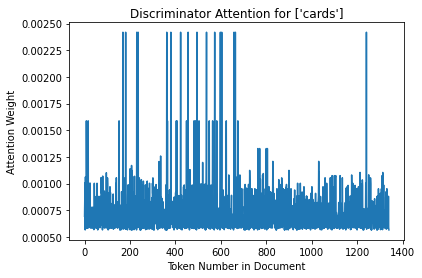

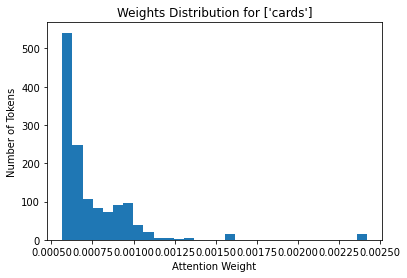

In [ ]:
#CHOOSE MAX FROM LIST AND PLOT

discriminator = 0 # Choose which question to plot the maximum discriminator from
max_discriminator_embedding = max_discriminator_embedding_list[discriminator]
output, weights = attention(max_discriminator_embedding, context_embeddings)
y = weights[0][0].tolist()
print(max(y) - find_max_mode(y))
#y_normalization = (sum (y) / len (y)) # Normalizing in order to add up attentions over words? Seems to always be 0.000745712?
#y = [rectified(idx - (2*0.000745712)) for idx in y] # We're normalizing to twice the mean in case we want to add up the attention scores across words 
x = list(range(len(context_ids[0]))) # Set x axis to length of context

plt.plot(x, y) # add 'bo' to make into bubbles
plt.xlabel("Token Number in Document")
plt.ylabel("Attention Weight")
plt.title(f"Discriminator Attention for {max_discriminator_token_list[discriminator]}")
plt.autoscale()
plt.show()

plt.hist(y, bins=30) # 30 bins is arbitrary
plt.title(f"Weights Distribution for {max_discriminator_token_list[discriminator]}")
plt.xlabel("Attention Weight")
plt.ylabel("Number of Tokens")
plt.autoscale()
plt.show()

['What kinds of cards are there ?', 'How many suits are there ?', 'What are the names of the suits ?', 'What is the play area ?', 'What do you do when you reveal a card ?', 'Are rivers treated as paths ?', 'What are forests adjacent to ?', 'Can I show cards in my hand ?', 'What does cannot mean ?', 'What are paths adjacent to ?', 'What happens if the deck is empty ?', 'What information is private ?', 'What is the map of the Woodland made of ?', 'What are enemies ?', 'What is a ruler ?', 'What do I do when I spend a card ?', 'What can I spend a dominance card for ?', 'What are ambush cards used for ?', 'Can players make agreements ?', 'When do certain rules take precedence ?', 'What happens if effects are simultaneous ?', 'What happens if two things happen at the same time ?', 'What are bird cards used for ?', 'How are ruins removed ?']
['[CLS]', 'what', 'are', 'the', 'names', 'of', 'the', 'suits', '?', '[SEP]']
0.0027174546266905963
0.0020380909700179473
1


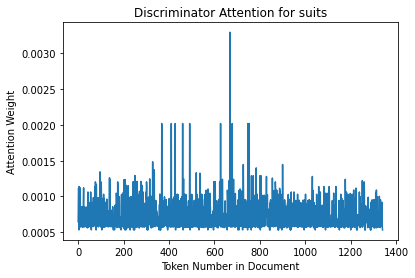

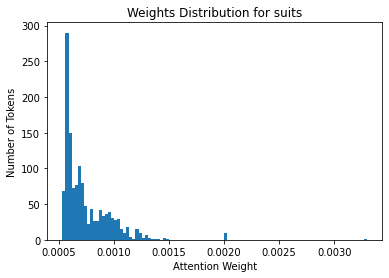

In [ ]:
print(question_list)

#EXTRACT TOKEN ATTENTIONS FOR A GIVEN QUESTION
which_question = 2
all_embedding_list, all_token_list = find_token_attentions(question_list,context,which_question)

#SELECT SPECIFIC TOKEN AS DISCRIMINATOR
print(all_token_list)
discriminator = 7 # Choose which token in the list to plot
discriminator_embedding = all_embedding_list[discriminator]
output, weights = attention(discriminator_embedding, context_embeddings)
y = weights[0][0].tolist()
discriminator_strength = max(y) - find_max_mode(y)
print(discriminator_strength)
three_fourths_difference = (3/4)*discriminator_strength
print(three_fourths_difference)
word_count = len([i for i in y if i > three_fourths_difference]) # Count number of words above threshold of 3/4 range
print(word_count)
#y_normalization = (sum (y) / len (y)) # Normalizing in order to add up attentions over words? Seems to always be 0.000745712?
#y = [rectified(idx - (2*0.000745712)) for idx in y] # Noramlize to twice the mean in case we want to add up the attention scores across words 
x = list(range(len(context_ids[0]))) # Set x axis to length of context

plt.plot(x, y) # add 'bo' to make into bubbles
plt.xlabel("Token Number in Document")
plt.ylabel("Attention Weight")
plt.title(f"Discriminator Attention for {all_token_list[discriminator]}")
plt.autoscale()
plt.show()

plt.hist(y, bins=100) # 30 bins is arbitrary
plt.title(f"Weights Distribution for {all_token_list[discriminator]}")
plt.xlabel("Attention Weight")
plt.ylabel("Number of Tokens")
plt.autoscale()
plt.show()

In [ ]:
#CREATE WEIGHTED AVERAGE OF EMBEDDINGS BASED ON DISCRIMINATOR STRENGTH
embedding_length = len(all_embedding_list) - 2 # IGNORE CLS AND SEP
total_discriminator_value = 0.0
current_discriminator_value_list = []
discriminator_weight_list = []
weighted_embedding_list = all_embedding_list[1:(embedding_length+1)] # initialize for later weighting
for idx in range (1,embedding_length+1): # IGNORE CLS and SEP
  discriminator_embedding = all_embedding_list[idx]
  #print(discriminator_embedding[0][0][0:4])
  #print(all_token_list[idx])
  output, weights = attention(discriminator_embedding, context_embeddings)
  y = weights[0][0].tolist()
  current_discriminator_value = max(y) - find_max_mode(y)
  total_discriminator_value += current_discriminator_value
  #print(f"Current: {current_discriminator_value}")
  current_discriminator_value_list.append(current_discriminator_value)
  #print(f"Appended: {current_discriminator_value_list[idx-1]}")
  #print(f"Total: {total_discriminator_value}")
  #print(" ")

for idx in range(len(current_discriminator_value_list)):  
  discriminator_weight_list.append(current_discriminator_value_list[idx] / total_discriminator_value)
  #print(f"Weight: {discriminator_weight_list[idx]}")
  #SOFTMAX INSTEAD?

discriminator_weight_list_tensor = torch.tensor(discriminator_weight_list)
#print(discriminator_weight_list_tensor)
#print(all_embedding_list[1][0][0][0:4])
#weighted_embedding_list = torch.mul(all_embedding_list[1][0][0], discriminator_weight_list_tensor[0])
#print(weighted_embedding_list[0:4])
for idx in range(1,embedding_length+1): # IGNORE CLS and SEP
#  print(all_embedding_list[idx][0][0][0:4])
  weighted_embedding_list[idx-1] = torch.mul(all_embedding_list[idx][0][0], discriminator_weight_list_tensor[idx-1])
  #print(weighted_embedding_list[idx-1][0:4])
#  print(weighted_embedding_list[idx][0][0])
#  print(weighted_embedding_list[idx])

#for idx in range(1): #,embedding_length-1):
#print(all_embedding_list[0])
#print(discriminator_weight_list[0])
#weighted_embedding_list[idx] = torch.multiply(all_embedding_list[idx],discriminator_weight_list[idx-1])
#print(all_embedding_list[idx])
#final_embedding = 

# THERE'S A BUG IN HERE SOMEWHERE. IT CAN'T BE RUN TWICE.

In [ ]:
#print(weighted_embedding_list[3][0:4])
print(len(weighted_embedding_list))
final_embedding = torch.sum(torch.stack([weighted_embedding_list[0],weighted_embedding_list[1],weighted_embedding_list[2],weighted_embedding_list[3]]), dim=0).unsqueeze(0).unsqueeze(0)
# NEED TO MAKE THIS VARIABLE WITH Q LENGTH
#print(final_embedding)
#print(final_embedding.size())

4


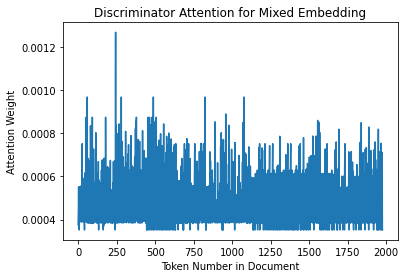

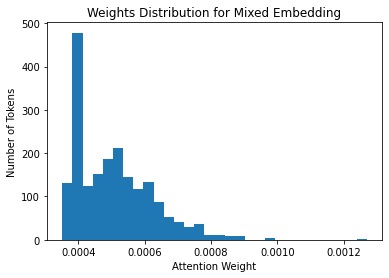

In [ ]:
## MIXED EMBEDDING PLOT
discriminator = 0 # Always zero in this case
output, weights = attention(final_embedding, context_embeddings)
y = weights[0][0].tolist()
x = list(range(len(context_ids[0]))) # Set x axis to length of context

plt.plot(x, y) # add 'bo' to make into bubbles
plt.xlabel("Token Number in Document")
plt.ylabel("Attention Weight")
plt.title(f"Discriminator Attention for Mixed Embedding")
plt.autoscale()
plt.show()

plt.hist(y, bins=30) # 30 bins is arbitrary
plt.title(f"Weights Distribution for Mixed Embedding")
plt.xlabel("Attention Weight")
plt.ylabel("Number of Tokens")
plt.autoscale()
plt.show()

In [ ]:
context_tokens = tokenizer.convert_ids_to_tokens(context_ids[0])
print(context_tokens)

['[CLS]', 'rules', 'conflicts', '[SEP]', 'precedence', '.', 'if', 'a', 'card', 'conflicts', 'with', 'the', 'law', ',', 'follow', 'the', 'card', '.', 'if', 'the', 'learning', 'to', 'play', 'guide', 'conflicts', 'with', 'the', 'law', ',', 'follow', 'the', 'law', '.', 'if', 'you', 'can', 'follow', 'both', 'a', 'general', 'rule', 'and', 'a', 'faction', 'rule', ',', 'follow', 'both', ';', 'if', 'you', 'cannot', ',', 'follow', 'the', 'faction', 'rule', '.', '[SEP]', 'use', 'of', 'cannot', '.', 'the', 'term', 'cannot', 'is', 'absolute', '.', 'it', 'cannot', 'be', 'over', '##rid', '##den', 'unless', 'explicitly', 'instructed', '.', '[SEP]', 'simultaneous', 'effects', '.', 'if', 'two', 'game', 'effects', 'occur', 'simultaneously', ',', 'the', 'player', 'taking', 'the', 'current', 'turn', 'chooses', 'their', 'order', ',', 'unless', 'explicitly', 'instructed', '.', '[SEP]', 'use', 'of', 'treat', '.', 'if', 'you', 'are', 'prompted', 'to', 'treat', 'one', 'thing', 'as', 'another', ',', 'the', 'form

In [ ]:
#BUILD FINAL CONTEXT

start_time = time.perf_counter()

iterator = len(context_ids[0])
separators = []
for widx in range(iterator):
  if context_ids[0][widx].item() == 102: # Find all separators - probably better way to do this in Python
    separators.append(widx)
separators = np.array(separators) # Convert to numpy array. Make more efficient later.
#Fixed top-k sampling - Need to build this out so you ignore duplicate window sizes
k = 10 # Choose k
res = sorted(range(len(y)), key = lambda sub: y[sub])[-k:] # Find top attention values
res = np.array(res)

window_list = []
iterator = len(res)
for widx in range(iterator):
  window_top = separators[separators > res[widx]].min()
  window_bottom = separators[separators < res[widx]].max()
  print((tokenizer.convert_ids_to_tokens(context_ids[0]))[res[widx]], ",", window_bottom, "-", window_top)
  window_list.append(range(window_bottom, window_top))

window_list = list(set(window_list)) # Delete duplicates. Probably inefficient.
#print("Final number of windows:", len(window_list))

window_id_list = []

for cidx in window_list:
  for i in cidx:
    window_id = context_ids[0][i]
    if window_id != 102: # Strip [SEP] tokens for model input
      window_id_list.append(window_id)
    #print(window_id)
window_token_list = tokenizer.convert_ids_to_tokens(window_id_list)
#print(window_id_list)
#print(window_token_list)
#print(len(window_id_list))

final_context_string = tokenizer.convert_tokens_to_string(window_token_list)
end_time = time.perf_counter()
print(f"Tokens in Final Context: {len(window_token_list)}")
print(f"Question List: {question_list}")
print(f"Final Context: {final_context_string}")
print(f"Time taken: {end_time-start_time} s")

# GET THE ANSWER SPAN

#print(question_list[discriminator])
#print(final_context_string)
inputs = tokenizer_qa(question_list[0],final_context_string,return_tensors='pt')
#print(inputs)
answer_start_scores, answer_end_scores = model_qa(**inputs)
#print(answer_start_scores)
answer_start = torch.argmax(answer_start_scores)  # get the most likely beginning of answer with the argmax of the score
answer_end = torch.argmax(answer_end_scores) + 1  # get the most likely end of answer with the argmax of the score
#print(answer_start)
#print(answer_end)
tokenizer_qa.convert_tokens_to_string(tokenizer_qa.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end]))

In [ ]:
#outputs = model(q_tokens, output_hidden_states=True)
#print(len(outputs[1][0][0][0])) # You've found the contextualized hidden states!